In [15]:
%reload_ext autoreload
%autoreload 2

In [2]:
!git clone https://github.com/NVlabs/edm

Cloning into 'edm'...


In [16]:
%cd edm

/home/jupyter/work/resources/edm/edm


In [75]:
import tqdm
import pickle
import numpy as np
import torch
from PIL import Image
import dnnlib
from torch_utils import distributed as dist
from solvers import EulerSolver, EDM, DDIMSolver, DPMSolver1

In [76]:
import os, shutil
from tqdm import tqdm
from fid import calculate_inception_stats, calculate_fid_from_inception_stats

# код с лекции

def save_model_samples(name, model, batch_size, num_samples, solver, num_steps, **sampling_params):
    if os.path.exists(name):
        shutil.rmtree(name) # перед сохранением изображений в папку папка очищается
    os.makedirs(name, exist_ok=True) # и пересоздается
    count = 0

    assert num_samples % 10 == 0

    with tqdm(total= num_samples) as pbar:
        while count < num_samples:
            cur_batch_size = min(num_samples - count, batch_size)
            noise = torch.randn(cur_batch_size, 3, 32, 32)
            out, _ = solver.sample(net, noise, num_steps=num_steps, **sampling_params)
            out = (out * 127.5 + 128).clip(0, 255).to(torch.uint8).permute(0, 2, 3, 1).cpu().numpy()
            for i in range(out.shape[0]):
                img = Image.fromarray(out[i])
                n_digits = len(str(count))
                img_name = (6 - n_digits) * '0' + str(count) + '.png'
                img.save(os.path.join(name, img_name))
                count += 1
                pbar.update(1)
                pbar.set_description('%d images saved' % (count,))


def calc_fid(image_path, ref_path, num_expected, batch):
    with dnnlib.util.open_url(ref_path) as f:
        ref = dict(np.load(f))

    mu, sigma = calculate_inception_stats(image_path=image_path, num_expected=num_expected, max_batch_size=batch)
    fid = calculate_fid_from_inception_stats(mu, sigma, ref['mu'], ref['sigma'])
    return fid

In [19]:
network_pkl = 'https://nvlabs-fi-cdn.nvidia.com/edm/pretrained/edm-cifar10-32x32-uncond-ve.pkl'

with dnnlib.util.open_url(network_pkl, verbose=(dist.get_rank() == 0)) as f:
    net = pickle.load(f)['ema'].eval().cuda()

In [32]:
steps_list = [10, 16, 20, 32, 50, 100, 200]

In [31]:
edm_solver = EDM()
edm_fids = []
for num_steps in steps_list:
    save_model_samples('edm', net, batch_size=256, num_samples=3000, solver=edm_solver, num_steps=num_steps // 2)
    fid = calc_fid(image_path='edm', ref_path='https://nvlabs-fi-cdn.nvidia.com/edm/fid-refs/cifar10-32x32.npz',
                        num_expected=3000, batch=256)
    print(f'Количество шагов: {num_steps}\nFID: {fid}')
    edm_fids.append(fid)
print(edm_fids)

3000 images saved: 100%|██████████| 3000/3000 [00:26<00:00, 112.69it/s]


Loading Inception-v3 model...
Loading images from "edm"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.79batch/s]


Количество шагов: 10
FID: 44.82339333901204


3000 images saved: 100%|██████████| 3000/3000 [00:39<00:00, 75.33it/s] 


Loading Inception-v3 model...
Loading images from "edm"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.74batch/s]


Количество шагов: 16
FID: 13.297516284904352


3000 images saved: 100%|██████████| 3000/3000 [00:48<00:00, 61.47it/s] 


Loading Inception-v3 model...
Loading images from "edm"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.66batch/s]


Количество шагов: 20
FID: 11.416331414279894


3000 images saved: 100%|██████████| 3000/3000 [01:15<00:00, 39.95it/s] 


Loading Inception-v3 model...
Loading images from "edm"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.78batch/s]


Количество шагов: 32
FID: 10.38161919536128


3000 images saved: 100%|██████████| 3000/3000 [01:54<00:00, 26.09it/s]


Loading Inception-v3 model...
Loading images from "edm"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.85batch/s]


Количество шагов: 50
FID: 10.298870261625545


3000 images saved: 100%|██████████| 3000/3000 [03:45<00:00, 13.29it/s]


Loading Inception-v3 model...
Loading images from "edm"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.62batch/s]


Количество шагов: 100
FID: 10.335412234772337


3000 images saved: 100%|██████████| 3000/3000 [07:26<00:00,  6.71it/s]


Loading Inception-v3 model...
Loading images from "edm"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.73batch/s]


Количество шагов: 200
FID: 10.411211654540878


  0%|          | 0/3000 [00:33<?, ?it/s]


KeyboardInterrupt: 

In [33]:
euler = EulerSolver()
euler_fids = []
for num_steps in steps_list:
    save_model_samples('euler', net, batch_size=256, num_samples=3000, solver=euler, num_steps=num_steps)
    fid = calc_fid(image_path='euler', ref_path='https://nvlabs-fi-cdn.nvidia.com/edm/fid-refs/cifar10-32x32.npz',
                        num_expected=3000, batch=256)
    print(f'Количество шагов: {num_steps}\nFID: {fid}')
    euler_fids.append(fid)
print(euler_fids)

3000 images saved: 100%|██████████| 3000/3000 [00:28<00:00, 103.92it/s]


Loading Inception-v3 model...
Loading images from "euler"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.70batch/s]


Количество шагов: 10
FID: 26.844461803981506


3000 images saved: 100%|██████████| 3000/3000 [00:42<00:00, 71.26it/s] 


Loading Inception-v3 model...
Loading images from "euler"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.72batch/s]


Количество шагов: 16
FID: 17.712410406935714


3000 images saved: 100%|██████████| 3000/3000 [00:50<00:00, 58.83it/s] 


Loading Inception-v3 model...
Loading images from "euler"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.72batch/s]


Количество шагов: 20
FID: 14.98302567970168


3000 images saved: 100%|██████████| 3000/3000 [01:17<00:00, 38.72it/s] 


Loading Inception-v3 model...
Loading images from "euler"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.78batch/s]


Количество шагов: 32
FID: 12.589618522239792


3000 images saved: 100%|██████████| 3000/3000 [01:57<00:00, 25.57it/s]


Loading Inception-v3 model...
Loading images from "euler"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.72batch/s]


Количество шагов: 50
FID: 11.364400188297951


3000 images saved: 100%|██████████| 3000/3000 [03:47<00:00, 13.17it/s]


Loading Inception-v3 model...
Loading images from "euler"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.73batch/s]


Количество шагов: 100
FID: 10.552214882122788


3000 images saved: 100%|██████████| 3000/3000 [07:28<00:00,  6.68it/s]


Loading Inception-v3 model...
Loading images from "euler"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.63batch/s]


Количество шагов: 200
FID: 10.449608579473674
[26.844461803981506, 17.712410406935714, 14.98302567970168, 12.589618522239792, 11.364400188297951, 10.552214882122788, 10.449608579473674]


In [41]:
ddim_linear = DDIMSolver()
ddim_linear_fids_200 = []
sampling_params = {
    "max_steps": 10,
    "steps_schedule": "linear",
    "beta_start" : 2e-5,
    "beta_end" : 2e-2 - 1e-4
}
for num_steps in steps_list:
    sampling_params["max_steps"] = num_steps
    save_model_samples('euler', net, batch_size=256, num_samples=3000, solver=ddim_linear, num_steps=200, **sampling_params)
    fid = calc_fid(image_path='euler', ref_path='https://nvlabs-fi-cdn.nvidia.com/edm/fid-refs/cifar10-32x32.npz',
                        num_expected=3000, batch=256)
    print(f'Количество шагов: {num_steps}\nFID: {fid}')
    ddim_linear_fids_200.append(fid)
print(ddim_linear_fids_200)

3000 images saved: 100%|██████████| 3000/3000 [00:26<00:00, 113.10it/s]


Loading Inception-v3 model...
Loading images from "euler"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.68batch/s]


Количество шагов: 10
FID: 22.93739399866815


3000 images saved: 100%|██████████| 3000/3000 [00:39<00:00, 75.96it/s] 


Loading Inception-v3 model...
Loading images from "euler"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.64batch/s]


Количество шагов: 16
FID: 16.096332556222816


3000 images saved: 100%|██████████| 3000/3000 [00:48<00:00, 61.78it/s] 


Loading Inception-v3 model...
Loading images from "euler"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.68batch/s]


Количество шагов: 20
FID: 15.25610274650886


3000 images saved: 100%|██████████| 3000/3000 [01:14<00:00, 40.04it/s] 


Loading Inception-v3 model...
Loading images from "euler"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.68batch/s]


Количество шагов: 32
FID: 12.78783796967799


3000 images saved: 100%|██████████| 3000/3000 [01:54<00:00, 26.14it/s]


Loading Inception-v3 model...
Loading images from "euler"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.69batch/s]


Количество шагов: 50
FID: 11.870070079133955


3000 images saved: 100%|██████████| 3000/3000 [03:45<00:00, 13.33it/s]


Loading Inception-v3 model...
Loading images from "euler"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.71batch/s]


Количество шагов: 100
FID: 11.18229354586694


3000 images saved: 100%|██████████| 3000/3000 [07:25<00:00,  6.73it/s]


Loading Inception-v3 model...
Loading images from "euler"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.63batch/s]


Количество шагов: 200
FID: 11.170857750532603
[22.93739399866815, 16.096332556222816, 15.25610274650886, 12.78783796967799, 11.870070079133955, 11.18229354586694, 11.170857750532603]


In [42]:
ddim_linear = DDIMSolver()
ddim_linear_fids_500 = []
sampling_params = {
    "max_steps": 10,
    "steps_schedule": "linear",
    "beta_start" : 2e-5,
    "beta_end" : 2e-2 - 1e-4
}
for num_steps in steps_list:
    sampling_params["max_steps"] = num_steps
    save_model_samples('euler', net, batch_size=256, num_samples=3000, solver=ddim_linear, num_steps=500, **sampling_params)
    fid = calc_fid(image_path='euler', ref_path='https://nvlabs-fi-cdn.nvidia.com/edm/fid-refs/cifar10-32x32.npz',
                        num_expected=3000, batch=256)
    print(f'Количество шагов: {num_steps}\nFID: {fid}')
    ddim_linear_fids_500.append(fid)
print(ddim_linear_fids_500)

3000 images saved: 100%|██████████| 3000/3000 [00:26<00:00, 113.05it/s]


Loading Inception-v3 model...
Loading images from "euler"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.73batch/s]


Количество шагов: 10
FID: 21.34097931643891


3000 images saved: 100%|██████████| 3000/3000 [00:39<00:00, 75.74it/s] 


Loading Inception-v3 model...
Loading images from "euler"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.75batch/s]


Количество шагов: 16
FID: 15.941764984252055


3000 images saved: 100%|██████████| 3000/3000 [00:48<00:00, 61.64it/s] 


Loading Inception-v3 model...
Loading images from "euler"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.69batch/s]


Количество шагов: 20
FID: 14.575030582320274


3000 images saved: 100%|██████████| 3000/3000 [01:14<00:00, 40.04it/s] 


Loading Inception-v3 model...
Loading images from "euler"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.58batch/s]


Количество шагов: 32
FID: 12.450652112287859


3000 images saved: 100%|██████████| 3000/3000 [01:54<00:00, 26.17it/s]


Loading Inception-v3 model...
Loading images from "euler"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.79batch/s]


Количество шагов: 50
FID: 11.641469473739653


3000 images saved: 100%|██████████| 3000/3000 [03:45<00:00, 13.33it/s]


Loading Inception-v3 model...
Loading images from "euler"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.67batch/s]


Количество шагов: 100
FID: 11.047213925043158


3000 images saved: 100%|██████████| 3000/3000 [07:25<00:00,  6.73it/s]


Loading Inception-v3 model...
Loading images from "euler"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.76batch/s]


Количество шагов: 200
FID: 10.521099252377805
[21.34097931643891, 15.941764984252055, 14.575030582320274, 12.450652112287859, 11.641469473739653, 11.047213925043158, 10.521099252377805]


In [43]:
ddim_linear = DDIMSolver()
ddim_linear_fids_1000 = []
sampling_params = {
    "max_steps": 10,
    "steps_schedule": "linear",
    "beta_start" : 2e-5,
    "beta_end" : 2e-2 - 1e-4
}
for num_steps in steps_list:
    sampling_params["max_steps"] = num_steps
    save_model_samples('euler', net, batch_size=256, num_samples=3000, solver=ddim_linear, num_steps=1000, **sampling_params)
    fid = calc_fid(image_path='euler', ref_path='https://nvlabs-fi-cdn.nvidia.com/edm/fid-refs/cifar10-32x32.npz',
                        num_expected=3000, batch=256)
    print(f'Количество шагов: {num_steps}\nFID: {fid}')
    ddim_linear_fids_1000.append(fid)
print(ddim_linear_fids_1000)

3000 images saved: 100%|██████████| 3000/3000 [00:26<00:00, 113.34it/s]


Loading Inception-v3 model...
Loading images from "euler"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.66batch/s]


Количество шагов: 10
FID: 21.84914491704103


3000 images saved: 100%|██████████| 3000/3000 [00:39<00:00, 75.53it/s] 


Loading Inception-v3 model...
Loading images from "euler"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.69batch/s]


Количество шагов: 16
FID: 17.69460420224748


3000 images saved: 100%|██████████| 3000/3000 [00:48<00:00, 61.94it/s] 


Loading Inception-v3 model...
Loading images from "euler"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.53batch/s]


Количество шагов: 20
FID: 15.653484062956188


3000 images saved: 100%|██████████| 3000/3000 [01:15<00:00, 39.93it/s] 


Loading Inception-v3 model...
Loading images from "euler"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.67batch/s]


Количество шагов: 32
FID: 13.88582033078037


3000 images saved: 100%|██████████| 3000/3000 [01:54<00:00, 26.15it/s]


Loading Inception-v3 model...
Loading images from "euler"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.68batch/s]


Количество шагов: 50
FID: 12.10152036598367


3000 images saved: 100%|██████████| 3000/3000 [03:45<00:00, 13.32it/s]


Loading Inception-v3 model...
Loading images from "euler"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.72batch/s]


Количество шагов: 100
FID: 11.217158953119739


3000 images saved: 100%|██████████| 3000/3000 [07:25<00:00,  6.73it/s]


Loading Inception-v3 model...
Loading images from "euler"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.74batch/s]


Количество шагов: 200
FID: 10.733317744845207
[21.84914491704103, 17.69460420224748, 15.653484062956188, 13.88582033078037, 12.10152036598367, 11.217158953119739, 10.733317744845207]


In [77]:
dpm = DPMSolver1()
dpm_fids = []
for num_steps in steps_list:
    save_model_samples('dpm', net, batch_size=256, num_samples=3000, solver=dpm, num_steps=num_steps)
    fid = calc_fid(image_path='dpm', ref_path='https://nvlabs-fi-cdn.nvidia.com/edm/fid-refs/cifar10-32x32.npz',
                        num_expected=3000, batch=256)
    print(f'Количество шагов: {num_steps}\nFID: {fid}')
    dpm_fids.append(fid)
print(dpm_fids)

3000 images saved: 100%|██████████| 3000/3000 [00:26<00:00, 113.27it/s]


Loading Inception-v3 model...
Loading images from "dpm"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.77batch/s]


Количество шагов: 10
FID: 18.97992915596248


3000 images saved: 100%|██████████| 3000/3000 [00:39<00:00, 75.34it/s] 


Loading Inception-v3 model...
Loading images from "dpm"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.69batch/s]


Количество шагов: 16
FID: 15.035623636760402


3000 images saved: 100%|██████████| 3000/3000 [00:48<00:00, 61.84it/s] 


Loading Inception-v3 model...
Loading images from "dpm"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.73batch/s]


Количество шагов: 20
FID: 13.778422199154326


3000 images saved: 100%|██████████| 3000/3000 [01:15<00:00, 39.94it/s] 


Loading Inception-v3 model...
Loading images from "dpm"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.76batch/s]


Количество шагов: 32
FID: 12.823173619311236


3000 images saved: 100%|██████████| 3000/3000 [01:54<00:00, 26.11it/s]


Loading Inception-v3 model...
Loading images from "dpm"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.61batch/s]


Количество шагов: 50
FID: 11.865536365643656


3000 images saved: 100%|██████████| 3000/3000 [03:45<00:00, 13.31it/s]


Loading Inception-v3 model...
Loading images from "dpm"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.77batch/s]


Количество шагов: 100
FID: 11.398817175470922


3000 images saved: 100%|██████████| 3000/3000 [07:25<00:00,  6.73it/s]


Loading Inception-v3 model...
Loading images from "dpm"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.77batch/s]


Количество шагов: 200
FID: 11.552937483966383
[18.97992915596248, 15.035623636760402, 13.778422199154326, 12.823173619311236, 11.865536365643656, 11.398817175470922, 11.552937483966383]


In [100]:
ddim_quad = DDIMSolver()
ddim_quad_fids_500 = []
sampling_params = {
    "max_steps": 10,
    "steps_schedule": "quad",
    "beta_start" : 2e-5,
    "beta_end" : 2e-2 - 1e-4
}
for num_steps in steps_list:
    sampling_params["max_steps"] = num_steps
    save_model_samples('ddim', net, batch_size=256, num_samples=3000, solver=ddim_linear, num_steps=500, **sampling_params)
    fid = calc_fid(image_path='ddim', ref_path='https://nvlabs-fi-cdn.nvidia.com/edm/fid-refs/cifar10-32x32.npz',
                        num_expected=3000, batch=256)
    print(f'Количество шагов: {num_steps}\nFID: {fid}')
    ddim_quad_fids_500.append(fid)
print(ddim_quad_fids_500)

3000 images saved: 100%|██████████| 3000/3000 [00:26<00:00, 112.41it/s]


Loading Inception-v3 model...
Loading images from "ddim"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.72batch/s]


Количество шагов: 10
FID: 19.121379715931724


3000 images saved: 100%|██████████| 3000/3000 [00:39<00:00, 75.43it/s] 


Loading Inception-v3 model...
Loading images from "ddim"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.80batch/s]


Количество шагов: 16
FID: 13.408820082870191


3000 images saved: 100%|██████████| 3000/3000 [00:48<00:00, 61.66it/s] 


Loading Inception-v3 model...
Loading images from "ddim"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.77batch/s]


Количество шагов: 20
FID: 12.37979227584584


3000 images saved: 100%|██████████| 3000/3000 [01:15<00:00, 39.91it/s] 


Loading Inception-v3 model...
Loading images from "ddim"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.79batch/s]


Количество шагов: 32
FID: 11.429108247627811


3000 images saved: 100%|██████████| 3000/3000 [01:54<00:00, 26.15it/s]


Loading Inception-v3 model...
Loading images from "ddim"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.74batch/s]


Количество шагов: 50
FID: 10.836312501378417


3000 images saved: 100%|██████████| 3000/3000 [03:45<00:00, 13.32it/s]


Loading Inception-v3 model...
Loading images from "ddim"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.69batch/s]


Количество шагов: 100
FID: 10.630137387291649


3000 images saved: 100%|██████████| 3000/3000 [07:25<00:00,  6.73it/s]


Loading Inception-v3 model...
Loading images from "ddim"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.57batch/s]


Количество шагов: 200
FID: 10.437190390768857
[19.121379715931724, 13.408820082870191, 12.37979227584584, 11.429108247627811, 10.836312501378417, 10.630137387291649, 10.437190390768857]


In [109]:
ddim_quad = DDIMSolver()
ddim_quad_fids_1000 = []
sampling_params = {
    "max_steps": 10,
    "steps_schedule": "quad",
    "beta_start" : 2e-5,
    "beta_end" : 2e-2 - 1e-4
}
for num_steps in steps_list:
    sampling_params["max_steps"] = num_steps
    save_model_samples('ddim', net, batch_size=256, num_samples=3000, solver=ddim_linear, num_steps=1000, **sampling_params)
    fid = calc_fid(image_path='ddim', ref_path='https://nvlabs-fi-cdn.nvidia.com/edm/fid-refs/cifar10-32x32.npz',
                        num_expected=3000, batch=256)
    print(f'Количество шагов: {num_steps}\nFID: {fid}')
    ddim_quad_fids_1000.append(fid)
print(ddim_quad_fids_1000)

3000 images saved: 100%|██████████| 3000/3000 [00:26<00:00, 112.97it/s]


Loading Inception-v3 model...
Loading images from "ddim"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.71batch/s]


Количество шагов: 10
FID: 19.648661172911112


3000 images saved: 100%|██████████| 3000/3000 [00:39<00:00, 75.79it/s] 


Loading Inception-v3 model...
Loading images from "ddim"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.67batch/s]


Количество шагов: 16
FID: 13.621542719260036


3000 images saved: 100%|██████████| 3000/3000 [00:48<00:00, 61.73it/s] 


Loading Inception-v3 model...
Loading images from "ddim"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.82batch/s]


Количество шагов: 20
FID: 12.552596827873849


3000 images saved: 100%|██████████| 3000/3000 [01:15<00:00, 39.89it/s] 


Loading Inception-v3 model...
Loading images from "ddim"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.75batch/s]


Количество шагов: 32
FID: 11.322509899813245


3000 images saved: 100%|██████████| 3000/3000 [01:54<00:00, 26.18it/s]


Loading Inception-v3 model...
Loading images from "ddim"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.66batch/s]


Количество шагов: 50
FID: 10.813587647393211


3000 images saved: 100%|██████████| 3000/3000 [03:45<00:00, 13.33it/s]


Loading Inception-v3 model...
Loading images from "ddim"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.70batch/s]


Количество шагов: 100
FID: 10.556677171370563


3000 images saved: 100%|██████████| 3000/3000 [07:25<00:00,  6.73it/s]


Loading Inception-v3 model...
Loading images from "ddim"...
Calculating statistics for 3000 images...


100%|██████████| 12/12 [00:01<00:00,  7.72batch/s]


Количество шагов: 200
FID: 10.369480978705399
[19.648661172911112, 13.621542719260036, 12.552596827873849, 11.322509899813245, 10.813587647393211, 10.556677171370563, 10.369480978705399]


In [110]:
ddim_fid_results = {
    "ddim_linear_200": ddim_linear_fids_200,
    "ddim_linear_500": ddim_linear_fids_500,
    "ddim_linear_1000": ddim_linear_fids_1000,
    "ddim_quad_500": ddim_quad_fids_500,
    "ddim_quad_1000": ddim_quad_fids_1000
}

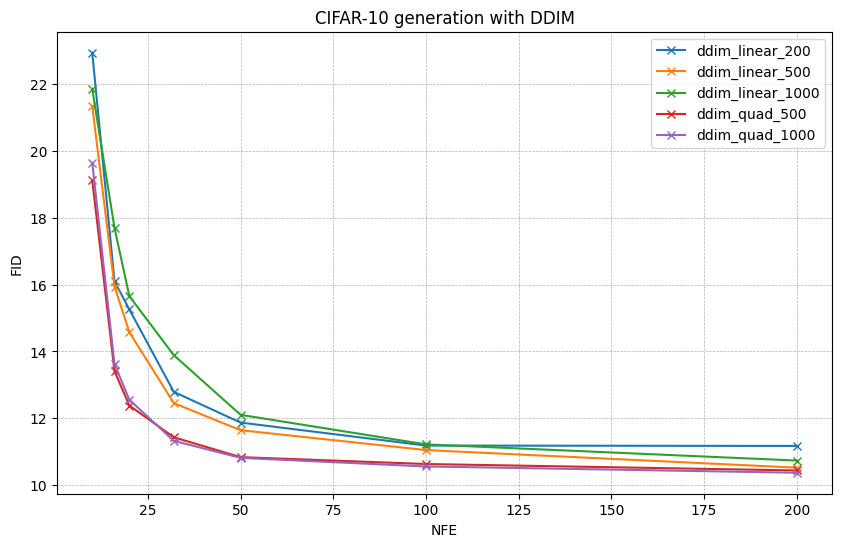

In [111]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for experiment_name, fids_list in ddim_fid_results.items():    
    plt.plot(steps_list, fids_list, marker='x', label=experiment_name)

plt.xlabel('NFE')
plt.ylabel('FID')
plt.title('CIFAR-10 generation with DDIM')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)

plt.show()

In [107]:
fid_results = {
    "euler": euler_fids,
    "edm": edm_fids,
    "ddim_quad": ddim_quad_fids_500,
    "dpm": dpm_fids
}

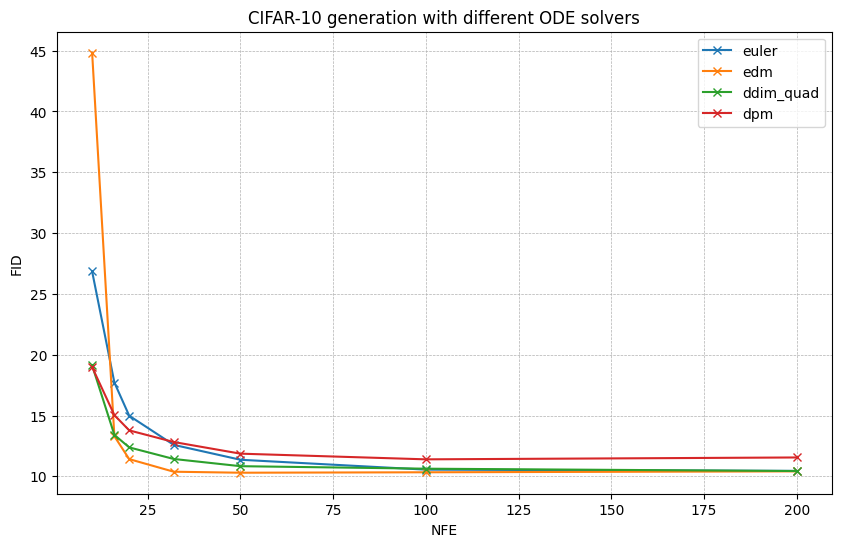

In [108]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for experiment_name, fids_list in fid_results.items():    
    plt.plot(steps_list, fids_list, marker='x', label=experiment_name)

plt.xlabel('NFE')
plt.ylabel('FID')
plt.title('CIFAR-10 generation with different ODE solvers')
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)

plt.show()